# Phase 3 Group Project:  Water Pumps in Tanzania

Presented by: Kelsey Lane, Andy Schmeck and Ted Brandon

Date:  10/29/2021

Instructor:  Angelica Spratley

github link:  https://github.com/andrewschmeck/Phase_3_Project-Kelsey-Ted-Andy

## Business Understanding

Andy will add this

##### Precision

Precision will be the metric used for this analysis.  This is due to the heavier weight of False Positives associated with this calculation.  Because some of these areas are quite remote, it is very important that we only send repair crews to the pumps/wells that are actually dysfunctional/malfunctioning.

## Data Understanding

Import the initial, necessary modules and import the data:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from pandas.core.common import SettingWithCopyWarning

df_feat = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
df_targ = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
df = pd.concat([df_feat, df_targ], axis = 1)

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Column Investigation (work in progress still)

#### Typical exploration:  .info(), .head(), .describe(), .value_counts(), etc.,...

__59,400 rows x 42 columns in this initial data set__

Drop unnecessary or redundant columns:

 - id (unnecessary)
 - extraction_type, extraction_type_group, extraction_type_class (redundant, keeping class)
 - scheme_name (redundant, keeping scheme_management)
 - payment (redundant, keeping payment type)
 - quality_group (redundant, keeping water_quality)
 - quantity_group (redundant, keeping quantity)
 - source_type (redundant, keeping source/source_class)
 - water_type_group (redundant, keeping waterpoint_type)
 - region_code, district_code, ward, subvillage, and lga (redundant, keeping region, latitude & longitude)
 - num_private (unnecessary, no info)
 - recorded_by (unnecessary, all rows have the same value)

Confusing Columns: (****still undecided on these****)

 - Management/management group seem different
 - Turn amount_tsh into 0 and not 0
 - Construction year missing values
  - make new column based on this - date recorded?
  - group into decades & unknown?
 - Group some categoricals into Top 5 and Other?
  - funder
  - installer
  - scheme_management
  - wpt_name
 - Population
  - is "0" unknown or no nearby population?
  - maybe consider grouping into 100s or 1000s?
 - Missing (recorded) info from:
  - funder
  - installer
  - gps_height
  - population
  - construction_year

Feature Creation:

 - Use date_recorded to make a Month column, or a Season column?
 - Use lga to make rural/urban/unknown before dropping?
 

#### Visualization of well locations in Tanzania, using latitude/longitude and altitude:
 - Locations overlay well with map of Tanzania, with altitude of wells correlating with mountain ranges, and empty patches matching with either bodies of water, or uninhabitable areas.

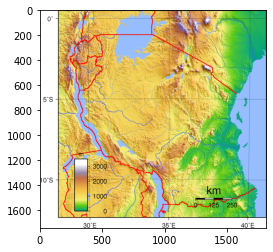

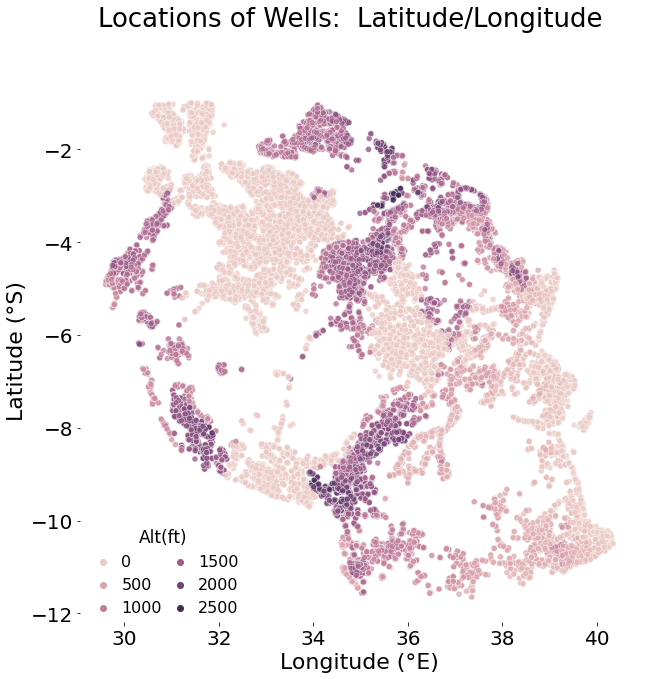

In [41]:
image = mpimg.imread("Images/Tanzania_Topography.png")
plt.imshow(image)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = df[df['latitude'] != 0]
df3 = df2[df2['longitude'] != 0]
sns.scatterplot(x = df3['longitude'], y = df3['latitude'], hue = df3['gps_height'],
                marker='o', alpha=0.75)
sns.despine(left=True,bottom=True)
plt.suptitle('Locations of Wells:  Latitude/Longitude', fontsize=26)
plt.xlabel('Longitude (°E)', fontsize=22)
plt.ylabel('Latitude (°S)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=16, loc='lower left', frameon=False, title='Alt(ft)',title_fontsize=17,
           ncol=2, labelspacing=0.5, columnspacing=0.1,borderaxespad=0.01,handletextpad=0.15);
# plt.savefig('Images/Tanzania_Wells.png', dpi=400, transparent=True);

### EDA & Cleaning

In [3]:
# Trimming columns based on above information:

df_trim = df.drop(columns = ['id', 'extraction_type', 'extraction_type_group', 'scheme_name',
                            'payment', 'quality_group', 'quantity_group', 'source_type',
                            'waterpoint_type_group', 'region_code', 'district_code', 'ward',
                            'subvillage', 'lga', 'num_private', 'recorded_by', 'funder',
                            'public_meeting'], axis = 1)

#Filling the nulls in "permit" with the mode, False

df_trim['permit'] = df_trim['permit'].fillna(value = False)

# 1,812 0-values for latitude/longitude, corresponding to 3.1% of the data, are dropped:

df_trim = df_trim[df_trim['longitude'] != 0]

__Missing values__ - Filling with "unknown" for categorical and median for boolean:

funder : 3635,
installer : 3655,
public_meeting : 3334,
scheme_management : 3877,
permit : 3056

#### Functionality `'status_group'` is the Target
This category has 3 values:  functional, non-functional and functional, needs repair.  The non/partially functional will be binned together, and the Target can now be treated as a binary system:

In [4]:
df_trim.status_group = df_trim.status_group.map({'functional' : 0, 'non functional': 1, 'functional needs repair': 1})
y = df_trim['status_group']

## Modeling

Bring in the necessary scikit learn goodies:

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

We need a few custom functions as well:

In [6]:
def install_bin(entry):
    if type(entry) == float:
        return 'other'
    elif entry.lower() in inst_list:
        return entry.lower()
    else:
        return 'other'

def scheme_bin(entry):
    if type(entry) == float:
        return 'other'
    elif entry.lower() in scheme_list:
        return entry.lower()
    else:
        return 'other'
    
def update_with_train(X_train):
    #long_mean = X_train.groupby('region')['longitude'].mean()
    #lat_mean = X_train.groupby('region')['latitude'].mean()
    inst_top_five = df_trim.installer.value_counts(sort = True, ascending = False)[:5]
    inst_top_five_list = list(inst_top_five.index)
    for idx, value in enumerate(inst_top_five_list):
        inst_top_five_list[idx] = value.lower()
        
    sch_top_five = df_trim.scheme_management.value_counts(sort = True, ascending = False)[:5]
    sch_top_five_list = list(sch_top_five.index)
    for idx, value in enumerate(sch_top_five_list):
        sch_top_five_list[idx] = value.lower()
        
    return inst_top_five_list, sch_top_five_list

### Dummy Model as Baseline

In [7]:
X = df_trim.drop(columns = ['status_group', 'date_recorded', 'wpt_name'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
        
scheme_eight = X_train.scheme_management.value_counts(sort = True, ascending = False)[:9]
scheme_list = list(scheme_eight.index)
for idx, value in enumerate(scheme_list):
    scheme_list[idx] = value.lower() 

X_train['installer'] = X_train['installer'].apply(install_bin)
X_train['scheme_management'] = X_train['scheme_management'].apply(scheme_bin)

X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

continuous_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 42, strategy = 'most_frequent'))
])

dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5445347410340117

### Base Model:

#### First Model - We'll go with a simple Decision Tree:

In [8]:
model_one = Pipeline(steps=[
    ('trans', trans),
    ('simple_dt', DecisionTreeClassifier(max_depth = 5, random_state = 42))
])

model_one.fit(X_train, y_train)
y_pred = model_one.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(model_one, X_train, y_train, cv=5, scoring = 'precision'))
print("Validation Score:" + str(scores))

Training Score:0.8543540842029507
Validation Score:0.8554167127994118


A basline precision of __0.854__/__0.855__ Train/Val - Fantastic!

### Model Iterations:

#### Tuning Decision Tree Parameters

Let's use a GridSearch to find the best parameters for our model:

In [9]:
# params = {
#     'simple_dt__criterion': ['gini', 'entropy'],
#     'simple_dt__min_samples_split': [2, 3, 5],
#     'simple_dt__min_samples_leaf': [1, 10, 100]
# }

# search = GridSearchCV(model_one, param_grid = params, scoring = 'precision')

# search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'construction_year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         Index(['installer', 'basin', 'region', 's...
       'extraction_type_class', 

In [10]:
search.best_params_

{'simple_dt__criterion': 'gini',
 'simple_dt__min_samples_leaf': 1,
 'simple_dt__min_samples_split': 2}

__So our un-tuned Decision Tree better__

#### Second Model - Logistic Regression

In [11]:
X = df_trim[['amount_tsh', 'permit', 'installer', 'extraction_type_class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()

X_train['installer'] = X_train['installer'].apply(install_bin)

X_train_cat = ['permit', 'installer', 'extraction_type_class']
X_train_cont = ['amount_tsh']

continuous_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont),
    ('categorical', categorical_pipeline, X_train_cat)
])

logreg = Pipeline(steps=[
    ('trans', trans),
    ('final_log', LogisticRegression(random_state = 42))
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(logreg, X_train, y_train, cv=5, scoring = 'precision'))
print("Validation Score:" + str(scores))

Training Score:0.753878952978799
Validation Score:0.7508032484079872


These scores compared to the baseline (0.854, 0.855) are a bit worse.

# ADD LOGISTIC REGRESSION ASSUMPTION

### Final Model:

Final, official results:

In [12]:
from sklearn.ensemble import RandomForestClassifier

final = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(random_state = 42))
])

final.fit(X_train, y_train)
y_pred = final.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(final, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score:0.7629366710255931
Validation Score:0.6688198285364692


In [13]:
# params = {
#     'rfc__criterion': ['gini', 'entropy'],
#     'rfc__n_estimators': [100, 300, 500],
#     'rfc__min_samples_split': [2, 5, 10]
# }

# search = GridSearchCV(final, param_grid = params, scoring = 'precision')

# search.fit(X_train, y_train)

In [14]:
search.best_params_

{'simple_dt__criterion': 'gini',
 'simple_dt__min_samples_leaf': 1,
 'simple_dt__min_samples_split': 2}

In [15]:
final_tuned = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(criterion = 'entropy', min_samples_split = 5, 
                                   n_estimators = 300, random_state = 42))
])

final_tuned.fit(X_train, y_train)
y_pred = final_tuned.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(final_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score:0.7627276973376926
Validation Score:0.6689818977305354


## Evaluation

## Interpretation

## Conclusions